In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np

import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import OxfordIIITPet
from torchvision import transforms
import torchvision as tv
import torch.nn.functional as F
from torch import Tensor

In [2]:
class MakeClass(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        uniques = torch.unique(x, sorted = True)
        for i, v in enumerate(uniques):
            x[x == v] = i
        return x.to(dtype=torch.long)

In [3]:
transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.ToTensor(), 
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

target_transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.ToTensor(), 
        MakeClass()
    ]
)

train_ds = OxfordIIITPet(
    root = "~/data", split = "trainval", target_types = "segmentation", transform = transform, 
    target_transform = target_transform, 
    download = True
)

test_ds = OxfordIIITPet(
    root = "~/data", split = "test", target_types = "segmentation", transform = transform, 
    target_transform = target_transform, 
    download = True
)

train_dl = DataLoader(train_ds, batch_size=64, shuffle=True, pin_memory = True, num_workers=24)
test_dl = DataLoader(test_ds, batch_size=64, shuffle=True, pin_memory = True, num_workers=24)

print("#Training Samples: {}".format(len(train_ds)))
print("#Testing Samples: {}".format(len(test_ds)))
print("#Training Batch: {}".format(len(train_dl)))
print("#Testing Batch: {}".format(len(test_dl)))

#Training Samples: 3680
#Testing Samples: 3669
#Training Batch: 58
#Testing Batch: 58


In [4]:
sample_data, sample_mask = train_ds[100]

print(f"data shape: {sample_data.shape}")
print(f"mask shape: {sample_mask.shape}")

print(f"Number classes: {np.unique(sample_mask.numpy())}")

data shape: torch.Size([3, 256, 256])
mask shape: torch.Size([1, 256, 256])
Number classes: [0 1 2]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


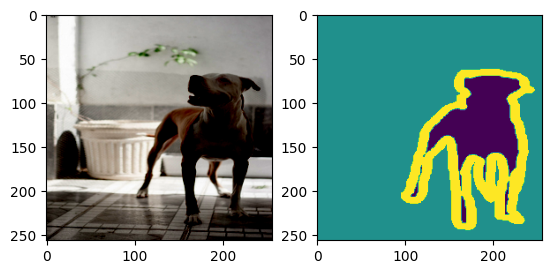

In [5]:
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(sample_data.cpu().permute(1, -1, 0).numpy())
axarr[1].imshow(sample_mask.cpu().permute(1, -1, 0).numpy())

In [6]:
class conv_block_nested(nn.Module):
    
    def __init__(self, in_ch, mid_ch, out_ch):
        super(conv_block_nested, self).__init__()
        self.activation = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_ch, mid_ch, kernel_size=3, padding=1, bias=True)
        self.bn1 = nn.BatchNorm2d(mid_ch)
        self.conv2 = nn.Conv2d(mid_ch, out_ch, kernel_size=3, padding=1, bias=True)
        self.bn2 = nn.BatchNorm2d(out_ch)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.activation(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        output = self.activation(x)

        return output

In [7]:
class NestedUNet(nn.Module):
    """
    Implementation of this paper:
    https://arxiv.org/pdf/1807.10165.pdf
    """
    def __init__(self, in_ch=3, out_ch=3, init_channel=16):
        super(NestedUNet, self).__init__()

        n1 = init_channel
        filters = [n1, n1 * 2, n1 * 4, n1 * 8, n1 * 16]

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv0_0 = conv_block_nested(in_ch, filters[0], filters[0])
        self.conv1_0 = conv_block_nested(filters[0], filters[1], filters[1])
        self.conv2_0 = conv_block_nested(filters[1], filters[2], filters[2])
        self.conv3_0 = conv_block_nested(filters[2], filters[3], filters[3])
        self.conv4_0 = conv_block_nested(filters[3], filters[4], filters[4])

        self.conv0_1 = conv_block_nested(filters[0] + filters[1], filters[0], filters[0])
        self.conv1_1 = conv_block_nested(filters[1] + filters[2], filters[1], filters[1])
        self.conv2_1 = conv_block_nested(filters[2] + filters[3], filters[2], filters[2])
        self.conv3_1 = conv_block_nested(filters[3] + filters[4], filters[3], filters[3])

        self.conv0_2 = conv_block_nested(filters[0]*2 + filters[1], filters[0], filters[0])
        self.conv1_2 = conv_block_nested(filters[1]*2 + filters[2], filters[1], filters[1])
        self.conv2_2 = conv_block_nested(filters[2]*2 + filters[3], filters[2], filters[2])

        self.conv0_3 = conv_block_nested(filters[0]*3 + filters[1], filters[0], filters[0])
        self.conv1_3 = conv_block_nested(filters[1]*3 + filters[2], filters[1], filters[1])

        self.conv0_4 = conv_block_nested(filters[0]*4 + filters[1], filters[0], filters[0])

        self.final = nn.Conv2d(filters[0], out_ch, kernel_size=1)


    def forward(self, x):
        
        x0_0 = self.conv0_0(x)
        x1_0 = self.conv1_0(self.pool(x0_0))
        x0_1 = self.conv0_1(torch.cat([x0_0, self.Up(x1_0)], 1))

        x2_0 = self.conv2_0(self.pool(x1_0))
        x1_1 = self.conv1_1(torch.cat([x1_0, self.Up(x2_0)], 1))
        x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.Up(x1_1)], 1))

        x3_0 = self.conv3_0(self.pool(x2_0))
        x2_1 = self.conv2_1(torch.cat([x2_0, self.Up(x3_0)], 1))
        x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.Up(x2_1)], 1))
        x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, self.Up(x1_2)], 1))

        x4_0 = self.conv4_0(self.pool(x3_0))
        x3_1 = self.conv3_1(torch.cat([x3_0, self.Up(x4_0)], 1))
        x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, self.Up(x3_1)], 1))
        x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, self.Up(x2_2)], 1))
        x0_4 = self.conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.Up(x1_3)], 1))

        output = self.final(x0_4)
        return output

In [8]:
def dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all batches, or for a single mask
    assert input.size() == target.size()
    assert input.dim() == 3 or not reduce_batch_first

    sum_dim = (-1, -2) if input.dim() == 2 or not reduce_batch_first else (-1, -2, -3)

    inter = 2 * (input * target).sum(dim=sum_dim)
    sets_sum = input.sum(dim=sum_dim) + target.sum(dim=sum_dim)
    sets_sum = torch.where(sets_sum == 0, inter, sets_sum)

    dice = (inter + epsilon) / (sets_sum + epsilon)
    return dice.mean()


def multiclass_dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all classes
    return dice_coeff(input.flatten(0, 1), target.flatten(0, 1), reduce_batch_first, epsilon)


def dice_loss(input: Tensor, target: Tensor, multiclass: bool = False):
    # Dice loss (objective to minimize) between 0 and 1
    fn = multiclass_dice_coeff if multiclass else dice_coeff
    return 1 - fn(input, target, reduce_batch_first=True)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu", index = 1)

model = NestedUNet().to(device)

optimizer = Adam(params = model.parameters(), lr = 0.001)

epochs = 100

scheduler = CosineAnnealingLR(optimizer, epochs * len(train_dl))

loss_fn = nn.CrossEntropyLoss()

In [10]:
old_loss = 1e26
best_dct = None
last_dst = None
for epoch in range(epochs):
    model.train()
    tr_total_loss = 0
    for train_img, train_mask in tqdm(train_dl):
        train_img = train_img.to(device)
        train_mask = train_mask.to(device, dtype = torch.long)

        train_gen_mask = model(train_img)
        train_rec_loss = loss_fn(train_gen_mask, train_mask.squeeze(1))
        train_dice_loss = dice_loss(
            F.softmax(train_gen_mask, dim=1).float(),
            F.one_hot(train_mask.squeeze(1), 3).permute(0, 3, 1, 2).float(),
            multiclass=True
        )
        train_loss = train_rec_loss + train_dice_loss

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        scheduler.step()

        tr_total_loss += train_loss.item()

    model.eval()
    with torch.no_grad():
        va_total_loss = 0
        for valid_img, valid_mask in tqdm(test_dl):
            valid_img = valid_img.to(device)
            valid_mask = valid_mask.to(device, dtype = torch.long)
            
            valid_gen_mask = model(valid_img)
            valid_loss = loss_fn(valid_gen_mask, valid_mask.squeeze(1))
            valid_dice_loss = dice_loss(
                F.softmax(valid_gen_mask, dim=1).float(),
                F.one_hot(valid_mask.squeeze(1), 3).permute(0, 3, 1, 2).float(),
                multiclass=True
            )
            valid_loss = train_rec_loss + train_dice_loss

            va_total_loss += valid_loss.item()
            
    mean_train_loss = tr_total_loss/len(train_dl)
    mean_valid_loss = va_total_loss/len(test_dl)

    if mean_valid_loss <= old_loss:
        old_loss = mean_valid_loss
        best_dct = model.state_dict()
    
    last_dct = model.state_dict()

    print(f"Epoch: {epoch} - TrainLoss: {mean_train_loss} - ValidLoss: {mean_valid_loss}")
model.load_state_dict(best_dct)

100%|██████████████████████████████████████████████████████| 58/58 [00:10<00:00,  5.28it/s]


Epoch: 0 - TrainLoss: 1.1869303255245602 - ValidLoss: 0.9966529607772827


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.27it/s]


Epoch: 1 - TrainLoss: 0.8519128694616515 - ValidLoss: 0.7139637470245361


100%|██████████████████████████████████████████████████████| 58/58 [00:10<00:00,  5.31it/s]


Epoch: 2 - TrainLoss: 0.7152202355450598 - ValidLoss: 0.7693723440170288


100%|██████████████████████████████████████████████████████| 58/58 [00:10<00:00,  5.29it/s]


Epoch: 3 - TrainLoss: 0.6318939996176752 - ValidLoss: 0.6440362334251404


100%|██████████████████████████████████████████████████████| 58/58 [00:10<00:00,  5.28it/s]


Epoch: 4 - TrainLoss: 0.5946039742436903 - ValidLoss: 0.5954773426055908


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.22it/s]


Epoch: 5 - TrainLoss: 0.5491240194131588 - ValidLoss: 0.5388288497924805


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.23it/s]


Epoch: 6 - TrainLoss: 0.5149314639897182 - ValidLoss: 0.48098841309547424


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.23it/s]


Epoch: 7 - TrainLoss: 0.5011487120184405 - ValidLoss: 0.4521724581718445


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.25it/s]


Epoch: 8 - TrainLoss: 0.47358999889472436 - ValidLoss: 0.4451685845851898


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.17it/s]


Epoch: 9 - TrainLoss: 0.44664431645952424 - ValidLoss: 0.4887259900569916


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.19it/s]


Epoch: 10 - TrainLoss: 0.43528980787458094 - ValidLoss: 0.4313849210739136


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.27it/s]


Epoch: 11 - TrainLoss: 0.4155888418699133 - ValidLoss: 0.39729389548301697


100%|██████████████████████████████████████████████████████| 58/58 [00:10<00:00,  5.33it/s]


Epoch: 12 - TrainLoss: 0.4033935578732655 - ValidLoss: 0.439698725938797


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.27it/s]


Epoch: 13 - TrainLoss: 0.3862627662461379 - ValidLoss: 0.3633069396018982


100%|██████████████████████████████████████████████████████| 58/58 [00:10<00:00,  5.28it/s]


Epoch: 14 - TrainLoss: 0.3693771829892849 - ValidLoss: 0.38570937514305115


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.20it/s]


Epoch: 15 - TrainLoss: 0.3582779472244197 - ValidLoss: 0.38262033462524414


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.21it/s]


Epoch: 16 - TrainLoss: 0.3566950688074375 - ValidLoss: 0.40908071398735046


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.22it/s]


Epoch: 17 - TrainLoss: 0.33896077809662656 - ValidLoss: 0.3268357813358307


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.25it/s]


Epoch: 18 - TrainLoss: 0.31258293215570776 - ValidLoss: 0.35673561692237854


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.21it/s]


Epoch: 19 - TrainLoss: 0.3147061076657525 - ValidLoss: 0.34758445620536804


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.23it/s]


Epoch: 20 - TrainLoss: 0.3109660544272127 - ValidLoss: 0.3002334237098694


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.22it/s]


Epoch: 21 - TrainLoss: 0.3096124355135293 - ValidLoss: 0.2975919842720032


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.18it/s]


Epoch: 22 - TrainLoss: 0.279130643297886 - ValidLoss: 0.2951652407646179


100%|██████████████████████████████████████████████████████| 58/58 [00:10<00:00,  5.29it/s]


Epoch: 23 - TrainLoss: 0.2668751398551053 - ValidLoss: 0.2732263207435608


100%|██████████████████████████████████████████████████████| 58/58 [00:10<00:00,  5.30it/s]


Epoch: 24 - TrainLoss: 0.2582234986897173 - ValidLoss: 0.25971782207489014


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.26it/s]


Epoch: 25 - TrainLoss: 0.2532964351362196 - ValidLoss: 0.2924727201461792


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.21it/s]


Epoch: 26 - TrainLoss: 0.2412641760090302 - ValidLoss: 0.22884786128997803


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.23it/s]


Epoch: 27 - TrainLoss: 0.24948157729773685 - ValidLoss: 0.23021697998046875


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.20it/s]


Epoch: 28 - TrainLoss: 0.24304382657182627 - ValidLoss: 0.23463915288448334


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.20it/s]


Epoch: 29 - TrainLoss: 0.2384727024312677 - ValidLoss: 0.22252222895622253


100%|██████████████████████████████████████████████████████| 58/58 [00:10<00:00,  5.29it/s]


Epoch: 30 - TrainLoss: 0.23525217637933535 - ValidLoss: 0.28658008575439453


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.25it/s]


Epoch: 31 - TrainLoss: 0.21718765461239323 - ValidLoss: 0.19960620999336243


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.22it/s]


Epoch: 32 - TrainLoss: 0.21047199466105165 - ValidLoss: 0.1996515989303589


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.20it/s]


Epoch: 33 - TrainLoss: 0.20631872040444407 - ValidLoss: 0.19973495602607727


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.20it/s]


Epoch: 34 - TrainLoss: 0.20329695888634386 - ValidLoss: 0.21820640563964844


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.26it/s]


Epoch: 35 - TrainLoss: 0.20302217787709728 - ValidLoss: 0.1917220801115036


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.18it/s]


Epoch: 36 - TrainLoss: 0.196566351785742 - ValidLoss: 0.17720277607440948


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.18it/s]


Epoch: 37 - TrainLoss: 0.19225813011670934 - ValidLoss: 0.19379273056983948


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.23it/s]


Epoch: 38 - TrainLoss: 0.18521263604534083 - ValidLoss: 0.17066997289657593


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.21it/s]


Epoch: 39 - TrainLoss: 0.18306754529476166 - ValidLoss: 0.17813172936439514


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.19it/s]


Epoch: 40 - TrainLoss: 0.17792016396234775 - ValidLoss: 0.18721912801265717


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.19it/s]


Epoch: 41 - TrainLoss: 0.17719151413646236 - ValidLoss: 0.18162459135055542


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.25it/s]


Epoch: 42 - TrainLoss: 0.1706379323170103 - ValidLoss: 0.15959663689136505


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.22it/s]


Epoch: 43 - TrainLoss: 0.16629836374315723 - ValidLoss: 0.19294136762619019


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.18it/s]


Epoch: 44 - TrainLoss: 0.1629098317232625 - ValidLoss: 0.16712847352027893


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.23it/s]


Epoch: 45 - TrainLoss: 0.16042251448179112 - ValidLoss: 0.23209449648857117


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.21it/s]


Epoch: 46 - TrainLoss: 0.16113378698455877 - ValidLoss: 0.15590399503707886


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.10it/s]


Epoch: 47 - TrainLoss: 0.15835775255129256 - ValidLoss: 0.15913039445877075


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.20it/s]


Epoch: 48 - TrainLoss: 0.15124492270165477 - ValidLoss: 0.1686284989118576


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.18it/s]


Epoch: 49 - TrainLoss: 0.14899390319298053 - ValidLoss: 0.18605279922485352


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.22it/s]


Epoch: 50 - TrainLoss: 0.14591349918266822 - ValidLoss: 0.14573080837726593


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.22it/s]


Epoch: 51 - TrainLoss: 0.14185032479721923 - ValidLoss: 0.14093106985092163


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.22it/s]


Epoch: 52 - TrainLoss: 0.13931277702594624 - ValidLoss: 0.1496952921152115


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.16it/s]


Epoch: 53 - TrainLoss: 0.14063237196412579 - ValidLoss: 0.14276021718978882


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.16it/s]


Epoch: 54 - TrainLoss: 0.1362488485615829 - ValidLoss: 0.15184208750724792


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.16it/s]


Epoch: 55 - TrainLoss: 0.13175404701253463 - ValidLoss: 0.12700335681438446


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.15it/s]


Epoch: 56 - TrainLoss: 0.13069622886591944 - ValidLoss: 0.15967918932437897


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.25it/s]


Epoch: 57 - TrainLoss: 0.12977915488440414 - ValidLoss: 0.15536916255950928


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.23it/s]


Epoch: 58 - TrainLoss: 0.12600111486069088 - ValidLoss: 0.12366354465484619


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.24it/s]


Epoch: 59 - TrainLoss: 0.1233377365459656 - ValidLoss: 0.12414653599262238


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.24it/s]


Epoch: 60 - TrainLoss: 0.12113307621972315 - ValidLoss: 0.12953388690948486


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.18it/s]


Epoch: 61 - TrainLoss: 0.119928655567868 - ValidLoss: 0.10962650179862976


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.20it/s]


Epoch: 62 - TrainLoss: 0.11670919571971071 - ValidLoss: 0.12035985291004181


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.20it/s]


Epoch: 63 - TrainLoss: 0.11445026253831797 - ValidLoss: 0.11509677022695541


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.21it/s]


Epoch: 64 - TrainLoss: 0.11325152924862401 - ValidLoss: 0.11867181211709976


100%|██████████████████████████████████████████████████████| 58/58 [00:10<00:00,  5.27it/s]


Epoch: 65 - TrainLoss: 0.11368928798313799 - ValidLoss: 0.1186707466840744


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.20it/s]


Epoch: 66 - TrainLoss: 0.11047172456465919 - ValidLoss: 0.11132406443357468


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.23it/s]


Epoch: 67 - TrainLoss: 0.11031342079413348 - ValidLoss: 0.10588028281927109


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.21it/s]


Epoch: 68 - TrainLoss: 0.10780258168434274 - ValidLoss: 0.11876647174358368


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.18it/s]


Epoch: 69 - TrainLoss: 0.10505710760581083 - ValidLoss: 0.10646770894527435


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.23it/s]


Epoch: 70 - TrainLoss: 0.10369002819061279 - ValidLoss: 0.1018979474902153


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.23it/s]


Epoch: 71 - TrainLoss: 0.10235467244838846 - ValidLoss: 0.11760681122541428


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.22it/s]


Epoch: 72 - TrainLoss: 0.10161628073145604 - ValidLoss: 0.11010561138391495


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.16it/s]


Epoch: 73 - TrainLoss: 0.10002845923962264 - ValidLoss: 0.10060276091098785


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.21it/s]


Epoch: 74 - TrainLoss: 0.10063093117084997 - ValidLoss: 0.11296675354242325


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.22it/s]


Epoch: 75 - TrainLoss: 0.09957057276162608 - ValidLoss: 0.10991737991571426


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.22it/s]


Epoch: 76 - TrainLoss: 0.0978000501877275 - ValidLoss: 0.10445069521665573


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.21it/s]


Epoch: 77 - TrainLoss: 0.09634874594108812 - ValidLoss: 0.0902366116642952


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.27it/s]


Epoch: 78 - TrainLoss: 0.09495349832136056 - ValidLoss: 0.10212136059999466


100%|██████████████████████████████████████████████████████| 58/58 [00:10<00:00,  5.28it/s]


Epoch: 79 - TrainLoss: 0.09464921224220045 - ValidLoss: 0.10426947474479675


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.24it/s]


Epoch: 80 - TrainLoss: 0.09377548715163922 - ValidLoss: 0.0933382660150528


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.20it/s]


Epoch: 81 - TrainLoss: 0.09354660107657828 - ValidLoss: 0.09823178499937057


100%|██████████████████████████████████████████████████████| 58/58 [00:10<00:00,  5.29it/s]


Epoch: 82 - TrainLoss: 0.09235592070838501 - ValidLoss: 0.08789064735174179


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.23it/s]


Epoch: 83 - TrainLoss: 0.09191494255230345 - ValidLoss: 0.1005212590098381


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.18it/s]


Epoch: 84 - TrainLoss: 0.09152983334557764 - ValidLoss: 0.10444731265306473


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.24it/s]


Epoch: 85 - TrainLoss: 0.09038217532737501 - ValidLoss: 0.09134483337402344


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.20it/s]


Epoch: 86 - TrainLoss: 0.09012630491934974 - ValidLoss: 0.09285739064216614


100%|██████████████████████████████████████████████████████| 58/58 [00:10<00:00,  5.29it/s]


Epoch: 87 - TrainLoss: 0.08987687618054192 - ValidLoss: 0.09202274680137634


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.23it/s]


Epoch: 88 - TrainLoss: 0.08936129972852509 - ValidLoss: 0.08896911144256592


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.25it/s]


Epoch: 89 - TrainLoss: 0.08919077983190274 - ValidLoss: 0.08750171959400177


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.19it/s]


Epoch: 90 - TrainLoss: 0.08867526529677983 - ValidLoss: 0.0976572185754776


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.15it/s]


Epoch: 91 - TrainLoss: 0.08868572372814705 - ValidLoss: 0.10126487910747528


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.18it/s]


Epoch: 92 - TrainLoss: 0.08835389696318528 - ValidLoss: 0.09278878569602966


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.18it/s]


Epoch: 93 - TrainLoss: 0.08800296832261414 - ValidLoss: 0.09500201046466827


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.25it/s]


Epoch: 94 - TrainLoss: 0.08734017045333467 - ValidLoss: 0.09634283185005188


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.18it/s]


Epoch: 95 - TrainLoss: 0.08751935524673297 - ValidLoss: 0.0871143639087677


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.22it/s]


Epoch: 96 - TrainLoss: 0.0878006801779928 - ValidLoss: 0.09474238753318787


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.20it/s]


Epoch: 97 - TrainLoss: 0.08779776520256338 - ValidLoss: 0.08715606480836868


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.18it/s]


Epoch: 98 - TrainLoss: 0.08755511597826562 - ValidLoss: 0.08616523444652557


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.22it/s]

Epoch: 99 - TrainLoss: 0.08754090617956786 - ValidLoss: 0.09035508334636688


<All keys matched successfully>

  0%|                                                               | 0/10 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 10%|█████▌                                                 | 1/10 [00:00<00:01,  5.02it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 30%|████████████████▌                                      | 3/10 [00:00<00:00, 10.49it/s]Clipping input data to the valid range for imshow with RGB data ([0

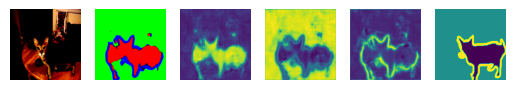

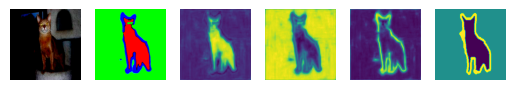

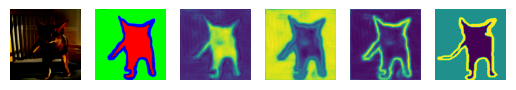

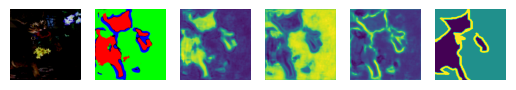

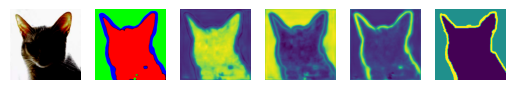

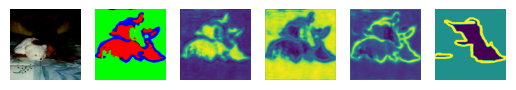

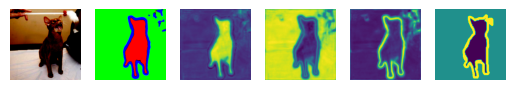

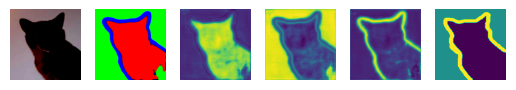

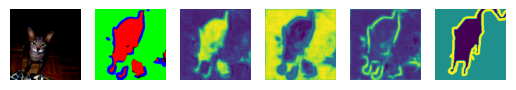

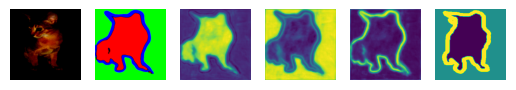

In [11]:
model.eval()
with torch.no_grad():
    for test_case_idx in tqdm(range(10)):
        valid_img, valid_mask = test_ds[test_case_idx]
        valid_img = valid_img.unsqueeze(dim=0).to(device)

        gen_mask = model(valid_img)     

        f, axarr = plt.subplots(1, 6)
        axarr[0].imshow(valid_img[0].cpu().permute(1, -1, 0).numpy())
        axarr[0].axis('off')
        axarr[1].imshow(gen_mask[0].cpu().permute(1, -1, 0).numpy())
        axarr[1].axis('off')
        axarr[2].imshow(gen_mask[0][0].unsqueeze(0).cpu().permute(1, -1, 0).numpy())
        axarr[2].axis('off')
        axarr[3].imshow(gen_mask[0][1].unsqueeze(0).cpu().permute(1, -1, 0).numpy())
        axarr[3].axis('off')
        axarr[4].imshow(gen_mask[0][2].unsqueeze(0).cpu().permute(1, -1, 0).numpy())
        axarr[4].axis('off')
        axarr[5].imshow(valid_mask.cpu().permute(1, -1, 0).numpy())
        axarr[5].axis('off')